# Compare output between BioNeMo2 And Evo2

In BioNeMo2, I have selected two fasta sequences, run predictions on them, and save the `input_ids` and generated `tokens_logits`.

Here, I apply Evo2's model on the same two fasta sequences, run predictions on them, and compare the `input_ids`, `logits`, and final predictions.

I find that while the `input_ids` between the two sequences line up, our model and evo2's output different logit values (and thus different predictions)

In [1]:
# Install dependencies
!pip install matplotlib pandas seaborn scikit-learn openpyxl

import torch
import glob
import json
from pathlib import Path
from Bio import SeqIO
import gzip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.metrics import roc_auc_score

# Set root path
os.chdir('../..')

In [2]:
from evo2.models import Evo2

# Load model
model = Evo2('evo2_1b_base')

/home/jwilber/anaconda3/envs/evo2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 59.67it/s]


Extra keys in state_dict: {'blocks.10.mixer.dense._extra_state', 'blocks.3.mixer.dense._extra_state', 'blocks.24.mixer.dense._extra_state', 'unembed.weight', 'blocks.17.mixer.dense._extra_state'}


/home/jwilber/anaconda3/envs/evo2/lib/python3.11/site-packages/transformer_engine/pytorch/module/base.py:630: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.loa

## Load in sequence used in bionemo2, and the bionemo2 predictions/logits for it, and compare

## 1. Load Selected Sequences

In [3]:
from Bio import SeqIO

# Read the FASTA file
file_path = "notebooks/brca1/brca1_selected_seq/brca1_selected_sequences.fasta"
sequences = {}

for record in SeqIO.parse(file_path, "fasta"):
    sequences[record.id] = str(record.seq)

# evo2 model needs an Array[str]

bionemo_selected_seqs = [v for k,v in sequences.items()]
bionemo_selected_seqs

['TTAAACACTTTTCAAACCAGGCAATATTTTAGGCCTACTGTATATTTGCATTTTGAGCTTCCAATACGGATAAGTGACTGGAAAAAGCAGCTAGGTTTAGGTTGAAAAACAACAACCCACCGGGGAACACATTTTAGCAAATTCTTCTGAAAGTCAAAAATGTTATAGTCATAGGTAAAAAGTTACAAAGAACTACCAATTGTCAGAAATAGCTGCCAATATTGACTTAGAAGACAGCAGAAGGAATTTTAGTTCAAGAAACCTAAAACAGGCTGAAAACCTTACCTACCCTATAGCTACCACAAATAACACTGTTTCCAGTCATGATCATTCCTGATCACATATTAAGACATAACTGCAAATTGTGCTATACTGTACTATATTAAAAGGAAGTGAAATATGATCCCTATCCTAGAACTTTCCATACAAATGAATGTAAAACACCATAAAAATTAATCTTAAGGCCGGGCGCGGTGGCTCACGCCTGTAATCCCAGCACTTTGGGAGGCCGAGGTGGGCGGATCACGAGGTCAGGAAGTGGAGACCATCCTGGCTAACACGGTGAAACCCCGTCTCTACTAAAAATACAAAAAATTAGCCGGGCGTGGTGGTGGACGCCTGTAGTCCCAGCTACTTGGGGGGCCGAGGCAGGAGAATGGCGTGAACCCGGGAGGCGGAGCTTGCAGTGAGCCGAGATGGCGCCACTGCACTCCGGCCTGGGTGAAAGAGCGAGACTCCGTCTCAAAAACAAAACAAACAAAAATTAATCTTAAGCCAGGCGCAGTGGCTCACGCCAGCACTTTGGAAGGCCGAGGCGGGTGGATCACGAGATCAGGACTTCAAGACCAGCCTGACCAACGTGATGAAACCCTATCTCTACTAAAAATACAAAATTAGCCGGCCACGGTGGCGTGCGCCTATAATCCCAGCTACTCAGGAGGCTGAGGCAGGAGAAGCGCTTGAACTTGAACCTGGCAGGCGGAGGTTGCAGTGAGCCA

## Comparing Preds

### BioNeMo Preds:

In [4]:
selected_dir = Path("notebooks/brca1/brca1_selected_seq")

# Find and load prediction files
selected_seq_pred_files = glob.glob(os.path.join(selected_dir, "predictions__rank_*.pt"))

# Load sequence ID maps (maps sequence ID -> prediction index)
with open(os.path.join(selected_dir, "seq_idx_map.json"), "r") as f:
    ref_seq_idx_map = json.load(f)

# Load predictions
bionemo_preds = torch.load(selected_seq_pred_files[0])
bionemo_preds

/tmp/ipykernel_3956696/3010489536.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bionemo_preds = torch.load(selected_seq_pred_files[0])


{'log_probs_seqs': tensor([-1.0852, -1.0871]), 'seq_idx': tensor([0, 1])}

### Get Preds From evo2's model:

In [5]:
model.score_sequences(bionemo_selected_seqs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.59it/s]


[np.float32(-0.9418016), np.float32(-0.94185793)]

## Thus: BioNeMo Preds != Evo2 Preds

For bionemo2 on the same sequence, we get:

`{'log_probs_seqs': tensor([-1.0852, -1.0871]), 'seq_idx': tensor([0, 1])}`

But arc gets:

`[np.float32(-0.9418016), np.float32(-0.94185793)]`

What about for just the output logits?

---

## Compare Logits For Same Sequence:

### BioNeMo logits:

In [7]:
selected_dir2 = Path("notebooks/brca1/brca1_selected_seq2")

selected_dir_just_foward = selected_dir2 / "just_forward2"


# Find and load prediction files
selected_seq_pred_just_forward_files = glob.glob(os.path.join(selected_dir_just_foward, "predictions__rank_*.pt"))

# Load sequence ID maps (maps sequence ID -> prediction index)
with open(os.path.join(selected_dir_just_foward, "seq_idx_map.json"), "r") as f:
    ref_seq_idx_map_jf = json.load(f)

# Load predictions
selected_preds_jf = torch.load(selected_seq_pred_just_forward_files[0])
print(f"logit shape: {selected_preds_jf['token_logits'].shape}")
selected_preds_jf

logit shape: torch.Size([2, 8192, 512])


/tmp/ipykernel_3956696/1079501660.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  selected_preds_jf = torch.load(selected_seq_pred_just_forward_files[0])


{'token_logits': tensor([[[-11.7500, -44.2500, -44.2500,  ..., -44.2500, -44.2500, -44.2500],
          [ -8.8125, -48.0000, -48.0000,  ..., -48.0000, -48.0000, -48.0000],
          [ -6.8438, -47.0000, -47.0000,  ..., -47.2500, -47.0000, -47.0000],
          ...,
          [ -9.5625, -42.0000, -42.0000,  ..., -42.0000, -42.0000, -42.0000],
          [ -8.8125, -37.0000, -37.0000,  ..., -37.0000, -37.0000, -37.0000],
          [ -9.6875, -41.7500, -41.7500,  ..., -42.0000, -41.7500, -41.7500]],
 
         [[-11.8125, -44.2500, -44.2500,  ..., -44.2500, -44.2500, -44.2500],
          [ -8.8750, -48.0000, -48.0000,  ..., -48.0000, -48.0000, -48.0000],
          [ -6.9375, -47.2500, -47.2500,  ..., -47.2500, -47.2500, -47.2500],
          ...,
          [ -9.5625, -40.7500, -40.7500,  ..., -41.0000, -40.7500, -40.7500],
          [ -9.5625, -41.7500, -41.7500,  ..., -41.7500, -41.7500, -41.7500],
          [ -8.9375, -37.2500, -37.2500,  ..., -37.5000, -37.2500, -37.2500]]]),
 'pad_mask':

## Evo2 Logits:

To get Evo2 logits, run through their `prepare_batch` func then pass thru model.

(Note - I've confirmed this is the same output they get via pdb):

In [8]:
def prepare_batch(
        seqs,
        prepend_bos: bool = False,
        device: str = 'cuda:0'
):
    """
    Takes in a list of sequences, tokenizes them, and puts them in a tensor batch.
    Tokenization is done directly by converting characters to ASCII values.
    e.g. TTA... -> ([84, 84, 65, ...)]
    """
    seq_lengths = [len(seq) for seq in seqs]
    print(f"seq_lens: {seq_lengths}")
    input_ids = []
    for seq in seqs:
        # Direct tokenization using list comprehension with ord()
        tokens = [ord(char) for char in seq]
        input_ids.append(
            torch.tensor(tokens, dtype=torch.long).to(device).unsqueeze(0)
        )
    input_ids = torch.cat(input_ids, dim=0)
    return input_ids, seq_lengths


In [9]:
input_ids, seq_lengths = prepare_batch(bionemo_selected_seqs, device='cuda:0', prepend_bos=False)
assert len(seq_lengths) == input_ids.shape[0]


seq_lens: [8192, 8192]


In [10]:
with torch.inference_mode():
        logits, _ = model(input_ids)

In [11]:
logits

(tensor([[[ -7.7188, -47.7500, -47.7500,  ..., -47.7500, -47.7500, -47.7500],
          [ -6.1875, -47.2500, -47.2500,  ..., -47.5000, -47.2500, -47.2500],
          [ -6.0625, -47.5000, -47.5000,  ..., -47.5000, -47.5000, -47.5000],
          ...,
          [ -6.3750, -42.7500, -42.7500,  ..., -42.7500, -42.7500, -42.7500],
          [ -6.3750, -46.5000, -46.5000,  ..., -46.7500, -46.5000, -46.5000],
          [ -6.1250, -43.2500, -43.2500,  ..., -43.2500, -43.2500, -43.2500]],
 
         [[ -7.6875, -47.5000, -47.5000,  ..., -47.5000, -47.5000, -47.5000],
          [ -6.1875, -47.5000, -47.5000,  ..., -47.5000, -47.5000, -47.5000],
          [ -6.0312, -47.5000, -47.5000,  ..., -47.5000, -47.5000, -47.5000],
          ...,
          [ -6.2188, -43.5000, -43.5000,  ..., -43.7500, -43.5000, -43.5000],
          [ -6.3125, -42.7500, -42.7500,  ..., -42.7500, -42.7500, -42.7500],
          [ -6.2188, -46.5000, -46.5000,  ..., -46.5000, -46.5000, -46.5000]]],
        device='cuda:0', dtyp

## Thus: BioNeMo 2 Logits != Evo2 Logits

Let's make sure the `input_ids` are the same.

---

## Compare `input_id`s


### BioNeMo2 Input Id's:

In [12]:
bionemo_input_ids = selected_preds_jf['input_ids']
bionemo_input_ids

tensor([[84, 84, 65,  ..., 84, 67, 65],
        [84, 84, 84,  ..., 84, 84, 67]])

### Evo2 Input Id's:

In [13]:
input_ids

tensor([[84, 84, 65,  ..., 84, 67, 65],
        [84, 84, 84,  ..., 84, 84, 67]], device='cuda:0')

In [14]:
torch.sum(input_ids[0].cpu() == bionemo_input_ids[0]) == 8192

tensor(True)

In [15]:
torch.sum(input_ids[1].cpu() == bionemo_input_ids[1]) == 8192

tensor(True)

---

# Conclusion:

Despite equal `input_id`s: BioNeMo2 and Evo2 Models produce different logits for the same fasta sequence.

## Appendix

More stuff

In [72]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def categorical_heatmap_comparison(preds1, preds2, title="Categorical Heatmap of Model Argmax Predictions"):
    preds1_np = preds1.flatten().cpu().numpy()
    preds2_np = preds2.flatten().cpu().numpy()

    # Stack both tensors for visualization (rows: model versions, columns: positions)
    data = np.vstack([preds1_np, preds2_np])

    # Create categorical colormap (e.g., 'tab10' for 10 distinct categories, 'Set3' for more)
    unique_values = np.unique(data)  # Get unique argmax values
    palette = sns.color_palette("tab10", n_colors=len(unique_values))  # Generate categorical colors
    lut = dict(zip(unique_values, palette))  # Map each unique value to a color
    data_colors = np.vectorize(lut.get)(data)  # Convert data values to colors

    # Create heatmap
    plt.figure(figsize=(12, 3))  # Wide and short for large tensors
    sns.heatmap(data, cmap=palette, cbar=True, xticklabels=500, yticklabels=["Model 1", "Model 2"])

    # Labels and Title
    plt.xlabel("Position in Tensor")
    plt.ylabel("Model Version")
    plt.title(title)

    plt.show()


### Compare Argmax of logits to each other

In [21]:
logits[0][0].argmax(dim=-1)

tensor([67, 84, 84,  ..., 67, 65, 67], device='cuda:0')

In [24]:
selected_preds_jf['token_logits'][0].argmax(dim=-1)

tensor([71, 84, 84,  ..., 84, 84, 84])

In [76]:
logits_evo2_1 = logits[0][0].argmax(dim=-1)
logits_bionemo_1 = selected_preds_jf['token_logits'][0].argmax(dim=-1)

logits_evo2_2 = logits[0][1].argmax(dim=-1)
logits_bionemo_2 = selected_preds_jf['token_logits'][1].argmax(dim=-1)

Percent logits same: Sequence 1: 0.3221435546875


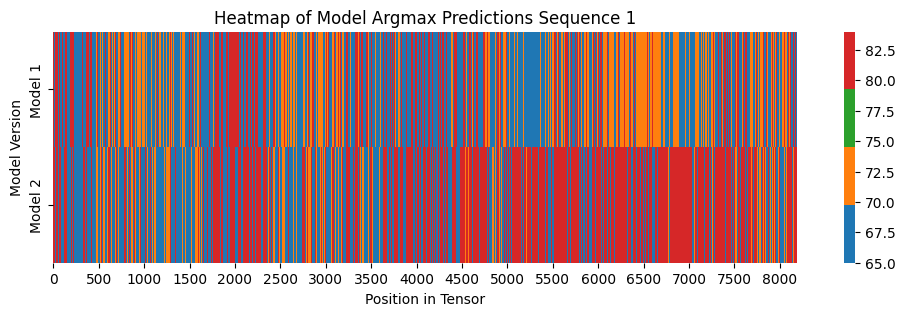

In [77]:
print(f"Percent logits same: Sequence 1: {(torch.sum(logits_evo2_1.cpu() == logits_bionemo_1.cpu()) / 8192.).item()}")
categorical_heatmap_comparison(logits_evo2_1, logits_bionemo_1, title="Heatmap of Model Argmax Predictions Sequence 1")

Percent logits same: Sequence 2: 0.3206787109375


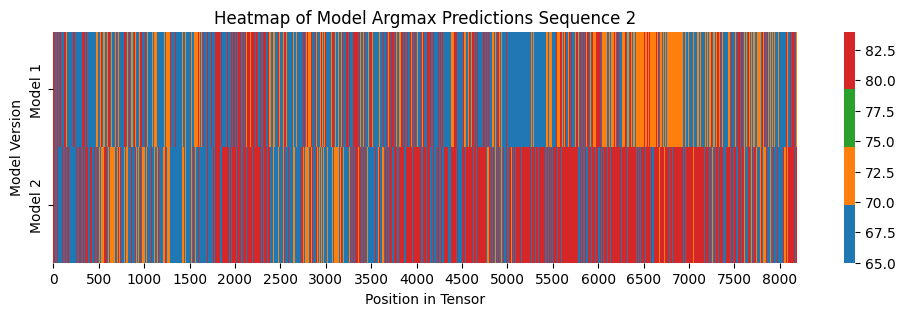

In [78]:
print(f"Percent logits same: Sequence 2: {(torch.sum(logits_evo2_2.cpu() == logits_bionemo_2.cpu()) / 8192.).item()}")
categorical_heatmap_comparison(logits_evo2_2, logits_bionemo_2, title="Heatmap of Model Argmax Predictions Sequence 2")